Copyright (c) 2015-2017 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book

[MIT License](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)

（日本語）  
[Python機械学習プログラミング 達人データサイエンティストによる理論と実践 (impress top gear)  
Sebastian Raschka  (著), 株式会社クイープ (翻訳), 福島真太朗 (翻訳)](https://www.amazon.co.jp/Python%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0-%E9%81%94%E4%BA%BA%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%83%86%E3%82%A3%E3%82%B9%E3%83%88%E3%81%AB%E3%82%88%E3%82%8B%E7%90%86%E8%AB%96%E3%81%A8%E5%AE%9F%E8%B7%B5-impress-top-gear/dp/4844380605)


# Python Machine Learning - Code Examples

# Chapter 11 - Working with Unlabeled Data – Clustering Analysis

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn

Sebastian Raschka 
last updated: 2017-05-20 

CPython 3.5.2
IPython 5.2.2

numpy 1.12.0
pandas 0.19.2
matplotlib 2.0.0
scipy 0.18.1
sklearn 0.18.1


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

<br>
<br>

### Overview

- [Grouping objects by similarity using k-means](#Grouping-objects-by-similarity-using-k-means)
  - [K-means++](#K-means++)
  - [Hard versus soft clustering](#Hard-versus-soft-clustering)
  - [Using the elbow method to find the optimal number of clusters](#Using-the-elbow-method-to-find-the-optimal-number-of-clusters)
  - [Quantifying the quality of clustering via silhouette plots](#Quantifying-the-quality-of-clustering-via-silhouette-plots)
- [Organizing clusters as a hierarchical tree](#Organizing-clusters-as-a-hierarchical-tree)
  - [Performing hierarchical clustering on a distance matrix](#Performing-hierarchical-clustering-on-a-distance-matrix)
  - [Attaching dendrograms to a heat map](#Attaching-dendrograms-to-a-heat-map)
  - [Applying agglomerative clustering via scikit-learn](#Applying-agglomerative-clustering-via-scikit-learn)
- [Locating regions of high density via DBSCAN](#Locating-regions-of-high-density-via-DBSCAN)
- [Summary](#Summary)

<br>
<br>

In [2]:
from IPython.display import Image
%matplotlib inline

# Grouping objects by similarity using k-means

データセットを生成します。

In [10]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150,   # サンプル点の総数
                  n_features=2,    # 特徴量の個数（今回は二次元）
                  centers=3,       # クラスタの個数
                  cluster_std=0.5, # クラスタ内の標準偏差
                  shuffle=True,    # サンプルをシャッフル
                  random_state=0)  # 乱数生成器の状態を指定

今回は以下のような分布を持つ点の集合を何かしらの基準でクラスタリングする手法（教師なし学習）を学びます。

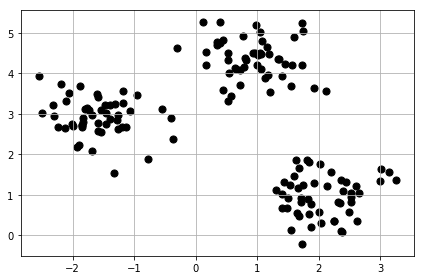

In [11]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c='black', marker='o', s=50)
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/spheres.png', dpi=300)
plt.show()

k-means法によるクラスタリングを行います。

### k-means法の流れ  
1. クラスタ中心の初期値として、サンプル点からk個のセントロイドをランダムに選び出す
2. 各サンプルを最も近いセントロイド**μ**<sup>(j)</sup>に割り当てる
3. セントロイドに割り当てられたサンプルの中心にセントロイドを移動する
4. サンプル点へのクラスタの割り当てが変化しなくなるか、ユーザー定義の許容値またはイテレーションの最大回数に達するまで、ステップ2〜3を繰り返す

オブジェクトの類似性はユークリッド距離のクラスタ内誤差平方和（SSE）を用いて評価する。

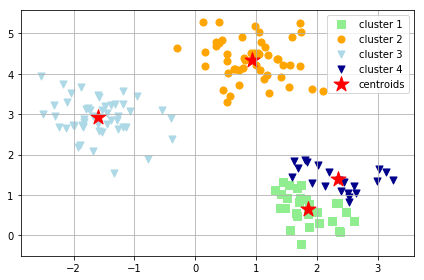

In [19]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4,   # クラスタの個数
            init='random',  # セントロイドの初期値をランダムに選択（デフォルトは‘k-means++’）
            n_init=10,      # 異なるセントロイドの初期値を用いたk-meansアルゴリズムの実行回数（n_init回繰り返し最終的に得られた結果を用いる）
            max_iter=5,   # k-meansアルゴリズム内部の最大繰り返し回数
            tol=10e-4,      # 収束と判定するための相対的な許容誤差
            random_state=0) # セントロイドの初期化に用いる乱数生成器の状態
y_km = km.fit_predict(X)    # クラスタ中心の計算と各サンプルのインデックスの予測

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50,
            c='lightblue',
            marker='v',
            label='cluster 3')
plt.scatter(X[y_km == 3, 0],
            X[y_km == 3, 1],
            s=50,
            c='darkblue',
            marker='v',
            label='cluster 4')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids.png', dpi=300)
plt.show()

* n_init
* max_iter
* tol
などパラメータを変えてみる。

<br>

## K-means++

オリジナルのk-means法では乱数を使ってセントロイドの初期値を設定した。  
従来のk-means法では、セントロイドの初期値が不適切である場合に、クラスタリングがうまくいかなかったり、収束に時間がかかったりすることがある。  
対応法としては以下の二つの戦略がある。  
1. k-meansアルゴリズムを1つのデータセットで複数回実行し、SSEが最も小さくなるものを選ぶ
2. k-means++法により、初期のセントロイドを互いに離れた位置に配置する

### k-means++法の流れ  
>  (引用: [Wikipedia k-means++法](https://ja.wikipedia.org/wiki/K-means%2B%2B%E6%B3%95))  
このk-means++法は、初期のk個のクラスタ中心はなるべく離れている方が良いという考えにもとづいている。まず始めにデータ点をランダムに選び1つ目のクラスタ中心とし、全てのデータ点とその最近傍のクラスタ中心の距離を求め、その距離の二乗に比例した確率でクラスタ中心として選ばれていないデータ点をクラスタ中心としてランダムに選ぶ。

1. 選択の対象となるk個のセントロイドを格納するために、空のデータセットMを初期化する
2. 入力サンプルから初期のセントロイド**μ**<sup>(j)</sup>をランダムに選択し、**M**に割り当てる
3. **M**に含まれていないサンプル**x**<sup>(i)</sup>ごとに、**M**のセントロイドに対して、距離の二乗が最小となるセントロイドを求める
4. 次のセントロイド**μ**<sup>(p)</sup>をランダムに選択するには、各サンプルの距離の重みを等しくした確率分布を使用する  
この操作で既に存在するセントロイドから離れた位置のセントロイドが選択されることになる  
正規化の必要性は何か？
5. k個のセントロイドが選択されるまで、ステップ3~4を繰り返す
6. 従来のk-means法を使って引き続き処理を行う

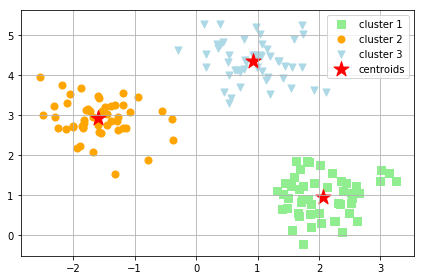

In [28]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,      # クラスタの個数
            init='k-means++',  # セントロイドの初期値をランダムに選択（デフォルトは‘k-means++’）
            n_init=10,          # n_init=1でもうまくいく
            max_iter=300,      # k-meansアルゴリズム内部の最大繰り返し回数
            tol=1e-4,         # 収束と判定するための相対的な許容誤差
            random_state=0)    # セントロイドの初期化に用いる乱数生成器の状態
y_km = km.fit_predict(X)       # クラスタ中心の計算と各サンプルのインデックスの予測

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50,
            c='lightblue',
            marker='v',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids.png', dpi=300)
plt.show()

## Hard versus soft clustering

ハードクラスタリング: データセットのサンプルがそれぞれちょうど1つのクラスタに割り当てられる。  
ソフトクラスタリング: データセットのサンプルが1つ以上のクラスタに割り当てられる。ファジークラスタリングとも呼ばれる。  

k-means法を拡張したソフトクラスタリングとしてFuzzy C-means(FCM)法が提案された。  
式（11.1.4）に示すように、FCM法では各サンプル点について各セントロイドに対する**[0, 1]**のクラスタメンバーシップ確率が所属関係として定義される。

### FCM法の流れ
1. セントロイドの個数kを指定し、各サンプル点に対してクラスタメンバーシップ確率をランダムに割り当てる
2. クラスタのセントロイドを計算する
3. 各サンプル点のクラスタメンバーシップ確率を更新する
4. クラスタメンバーシップ確率の係数が変化しなくなるか、ユーザー定義の許容値またはイテレーションの最大回数に達するまで、ステップ2~3を繰り返す

FCMの目的関数は式（11.1.5）に示すようにk-means法におけるSSEと似た式で定義される。  
ファジー係数が大きいほど重みは小さくなり、よりファジーな（曖昧な）クラスタとなる。

FCM法の各イテレーションのコストはk-means法よりも高いが、一般的には収束するまでのイテレーションの回数はFCM法の方が少ない。  
K-means法とFCM法が生成するクラスタリング出力は非常に似ていることがわかっている<sup>*</sup>。
* S. Ghosh and S. K. Dubey. *Comparative Analysis of k-means and Fuzzy c-means Algorithms.* IJACSA, 4:35-38, 2013

In [26]:
(10*10+11*11)/(10*10)

2.21

In [25]:
(10*10+11*11)/(11*11)

1.8264462809917354

## Using the elbow method to find the optimal number of clusters 

クラスタ内SSE（歪み）を指標に用いてk-meansクラスタリングの性能を評価する

In [29]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


SSEに基づいたエルボー法により、タスクに最適なクラスタ数kを推定できる  
kの値が増えれば、SSEは収束に向かう。エルボー法ではSSEが急速に変化するkの値を特定し、最適なクラスタ数kを推定する。

以下の例では、k=3がエルボー（肘）となっており、k=3がよい選択であると判断できる。

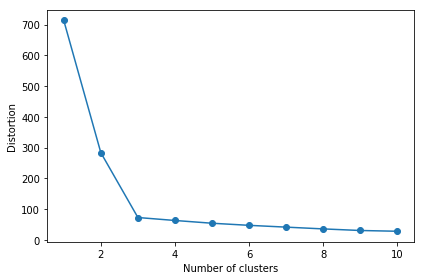

In [30]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('./figures/elbow.png', dpi=300)
plt.show()

<br>

## Quantifying the quality of clustering  via silhouette plots

クラスタリングの性能評価はシルエット分析を使って行うこともできる。  
シルエット分析はk-means法以外のクラスタリングアルゴリズムにも適用できる。

### シルエット分析の流れ
1. サンプル**x**<sup>(i)</sup>と同じクラスタ内のその他すべてのサンプルとの平均距離として、クラスタの凝集度**a**<sup>(i)</sup>を計算する。
2. サンプル**x**<sup>(i)</sup>と最も近くにあるクラスタ内のすべてのサンプルとの平均距離として、その次に近いクラスタからの乖離度**b**<sup>(i)</sup>を計算する。
3. クラスタの凝集度と乖離度の差（乖離度-凝集度）を、それらのうち大きいほうの値で割り、シルエット係数**s**<sup>(i)</sup>を計算する。

凝集度**a**<sup>(i)</sup>は小さいほど凝集している  
乖離度**b**<sup>(i)</sup>は大きいほど乖離している

**a**<sup>(i)</sup> << **b**<sup>(i)</sup>の時、**s**<sup>(i)</sup>は理想的なシルエット係数1に近づく。  
**b**<sup>(i)</sup> << **a**<sup>(i)</sup>の時、**s**<sup>(i)</sup>は-1に近づく。この時、サンプル**x**<sup>(i)</sup>は所属するクラスタよりも、最も近くにあるクラスタの方により近いことを表している。

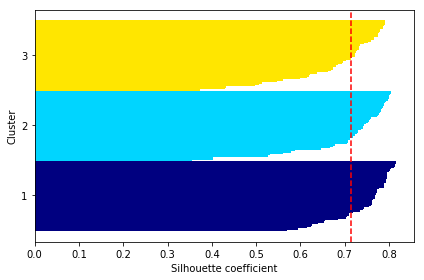

In [31]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

Comparison to "bad" clustering:  
本来3クラスタと考えられるデータセットで、セントロイドを2つだけ指定してみる。

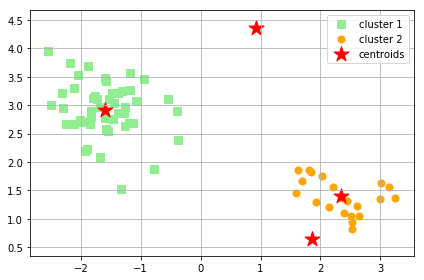

In [33]:
km = KMeans(n_clusters=4,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids_bad.png', dpi=300)
plt.show()

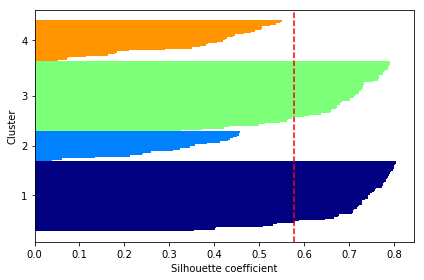

In [34]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette_bad.png', dpi=300)
plt.show()

<br>
<br>

# Organizing clusters as a hierarchical tree

### 階層的クラスタリング  

* 分割型: まずすべてのサンプルを包含する1つのクラスタを定義し、すべてのクラスタにサンプルが1つだけ含まれた状態になるまで、クラスタをより小さなクラスタに分割していく。
* 凝集型: 個々のサンプルを1つのクラスタとして扱い、クラスタが1つだけ残った状態になるまで、最も近くにある2つのクラスタをマージしていく
 * 単連結法: クラスタのペアごとに最も類似度の高いメンバーどうしの距離を計算し、最も類似度の高いメンバーどうしの距離が最小になるような方法で2つのクラスタをマージする。
 * 完全連結法: クラスタのペアごとに最も類似度の低いメンバーどうしの距離を計算し、最も類似度の低いメンバーどうしの距離が最小になるような方法で2つのクラスタをマージする。


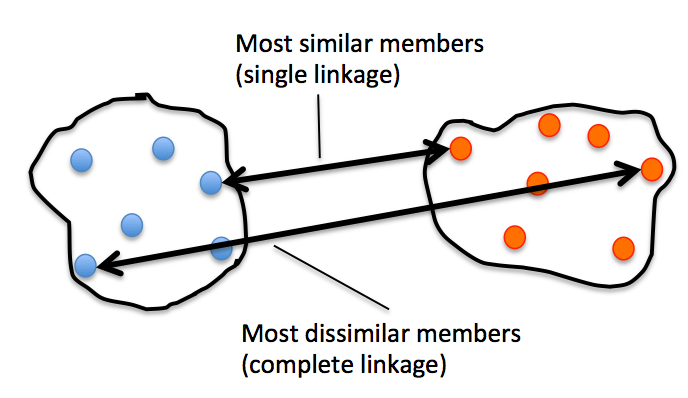

In [27]:
Image(filename='./images/11_05.png', width=400) 

### 完全連結法に基づく凝集型階層的クラスタリングの流れ

1. すべてのサンプルの距離行列を計算する
2. 各データ点を単一のクラスタとみなして表現する
3. 最も類似度の低い（最も離れた）メンバーの距離に基づき、2つの最も近いクラスタをマージする
4. 距離行列を更新する
5. クラスタが1つだけ残った状態になるまで、ステップ3~4を繰り返す

In [35]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


<br>

## Performing hierarchical clustering on a distance matrix

In [37]:
from scipy.spatial.distance import pdist, squareform
# pdistで距離を計算、squareformで対象行列を作成
print(pdist(df, metric='euclidean'))
print(squareform(pdist(df, metric='euclidean')))
row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

[ 4.973534    5.51665266  5.89988504  3.83539555  4.34707339  5.10431109
  6.69823298  7.24426159  8.31659367  4.382864  ]
[[ 0.          4.973534    5.51665266  5.89988504  3.83539555]
 [ 4.973534    0.          4.34707339  5.10431109  6.69823298]
 [ 5.51665266  4.34707339  0.          7.24426159  8.31659367]
 [ 5.89988504  5.10431109  7.24426159  0.          4.382864  ]
 [ 3.83539555  6.69823298  8.31659367  4.382864    0.        ]]


,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


We can either pass a condensed distance matrix (upper triangular) from the `pdist` function, or we can pass the "original" data array and define the `metric='euclidean'` argument in `linkage`. However, we should not pass the squareform distance matrix, which would yield different distance values although the overall clustering could be the same.

### scipy.cluster.hierarchy.linkage 関数を使用する時の注意点
linkage関数は圧縮済みの距離行列（pdistで得られる）を第一引数に与える、または初期データ配列を第一引数に与え、metricパラメータでeuclideanを指定するという使い方をする。squareformで得られた距離行列の対象行列を使用するべきではない。

row labelの番号の付き方は？

In [38]:
# 1. incorrect approach: Squareform distance matrix

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [39]:
# 2. correct approach: Condensed distance matrix

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [41]:
# 3. correct approach: Input sample matrix

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


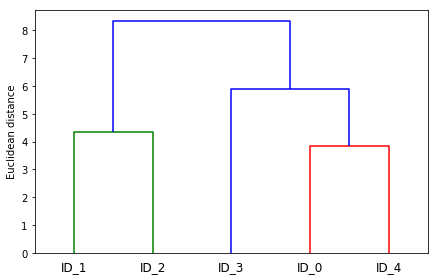

In [42]:
from scipy.cluster.hierarchy import dendrogram

# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('./figures/dendrogram.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

<br>

## Attaching dendrograms to a heat map

単純な樹形図に加えて、各サンプルと特徴量のカラーコード値をヒートマップで示すことで、データセットがうまく要約される。

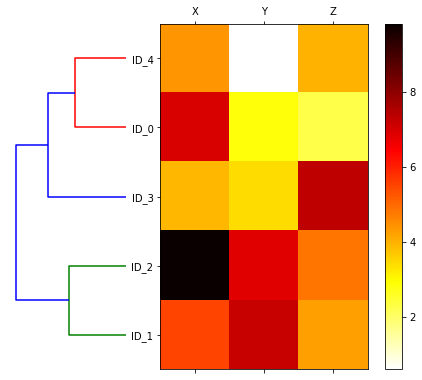

In [43]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

# plt.savefig('./figures/heatmap.png', dpi=300)
plt.show()

<br>

## Applying agglomerative clustering via scikit-learn

scikit-learnではAgglomerativeClusteringが実装されている。このクラスを利用すれば、取得したいクラスタの数を選択できるようになる。  
階層クラスタ木を剪定したい場合に役立つ。

In [45]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3,         # クラスタの個数
                             affinity='euclidean', # 類似度の指標
                             linkage='complete')   # 連結方法
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 0 0 2 1]


<br>
<br>

# Locating regions of high density via DBSCAN

### Density-based Spatial Clustering of Applications with Noise (DBSCAN)

* 指定された半径ε以内に少なくとも指定された個数（MinPts）の隣接点があるような点は、コア点（core point）と見なされる。
* 半径ε以内の隣接点の個数がMinPtsに満たないものの、コア点の半径ε以内に位置するような点は、ボーダー点（border point）と見なされる。
* コア点でもボーダー点でもないその他の点はすべてノイズ点（noise point）と見なされる。

上記のラベル付けの後、以下の手順でクラスタが決定される。

1. コア点ごとに、またはコア点の接続関係に基づいて、別々のクラスタを形成する。コア点どうしが接続関係を持つのは、それらがε以内にある場合である。
2. 各ボーダー点を、それと組になっているコア点のクラスタに割り当てる。

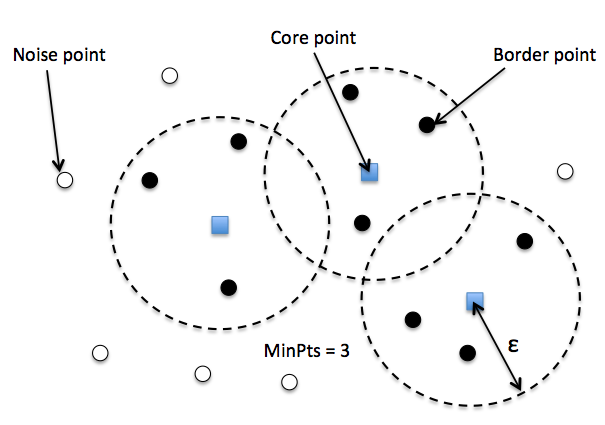

In [43]:
Image(filename='./images/11_11.png', width=500) 

### DBSCANが優れている点
DBSCANはk-means法と異なり「クラスタが球状である」ことを前提としていない。  
すべての点をクラスタに割り当てる必要がなく、ノイズ点を除去する能力を持つ。

半月状の構造を持つデータセットで比較を行う。

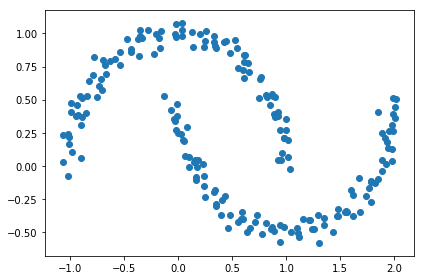

In [46]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200,  # 生成する点の総数
                  noise=0.05,     # 生成する点に追加するガウスノイズの標準偏差
                  random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
# plt.savefig('./figures/moons.png', dpi=300)
plt.show()

K-means and hierarchical clustering:

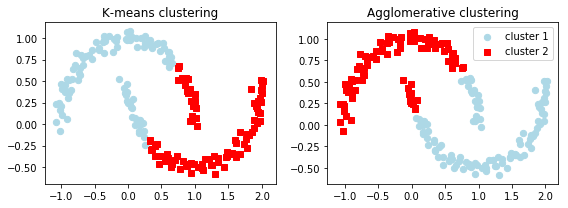

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
#plt.savefig('./figures/kmeans_and_ac.png', dpi=300)
plt.show()

Density-based clustering:

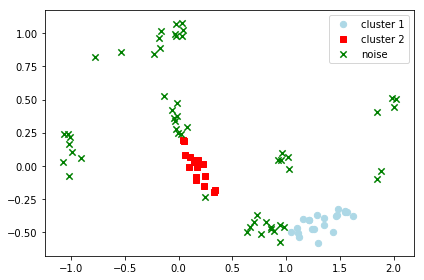

In [60]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.15,            # 隣接点とみなす2点間の最大距離
            min_samples=10,      # ボーダー点の最小個数
            metric='euclidean') # 距離の計算法
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0],
            X[y_db == 0, 1],
            c='lightblue',
            marker='o',
            s=40,
            label='cluster 1')
plt.scatter(X[y_db == 1, 0],
            X[y_db == 1, 1],
            c='red',
            marker='s',
            s=40,
            label='cluster 2')
plt.scatter(X[y_db == -1, 0],
            X[y_db == -1, 1],
            c='green',
            marker='x',
            s=40,
            label='noise')
plt.legend()
plt.tight_layout()
#plt.savefig('./figures/moons_dbscan.png', dpi=300)
plt.show()

DBSCANは半月状のクラスタをうまく検出できる。

### DBSCANを用いる際の注意点
* ユークリッド距離を指標に用いる場合（大半の場合？）次元の呪いが生じる。k-means法、階層型クラスタリングでも同様の問題は生じる。
* εとMinPtsという二つのハイパーパラメータを最適化する必要がある、

<br>
<br>

# Summary

...